### Purpose

This demo will see results for a realistic test case

### Loading Parameters

Below, I load relevant parameters. (This corresponds to Test Case 4 Variation 1 (Imperfect Learning, Undersampling)). This code will take some time.

In [2]:
import numpy as np

########################
# File Data
########################
filename0_ = 'demo4'
savetopath_ = './'

########################
# Bayes Risk Parameters
########################
max_it_BR_ = 50
num_randparams_ = 50
space_size_ = np.arange(-8,3)
truncation_ = 20
bayes_params_ = [max_it_BR_, num_randparams_, space_size_,truncation_]

########################
# Experiment Parameters
########################
n_train_ = 2000
n_predict_ = 50
n_testbefore_ = 50
multiplier_ = 20.0 
bandwidth_ = 50.0

exp_params_ = [n_train_, n_predict_, n_testbefore_, multiplier_, bandwidth_]

########################
# Truth Parameters - Test Case 4 Variation 1 (Imperfect Learning, Undersampling)
########################

apriori_f_mean_ = 0.0 
alpha_ = 1.0
f0_ = 2.0*(4.0/3.0)*4.0*10**(-4)
p_ = -1 #1 #-2 #-1 #0.0
J_ = int((1.0/2.0)*(3.0/4.0)*10**5)
jstart_ = 1 # (not zero)
pdf_type_u_ = 'Uniform'
      
true_noise_params_ = [apriori_f_mean_, pdf_type_u_, alpha_, f0_, p_, J_, jstart_]

########################
# Measurement Noise 
########################
msmt_noise_mean_ = 0.0 
msmt_noise_level_ = 0.01 

msmt_noise_params_ = [msmt_noise_mean_, msmt_noise_level_]

########################
# Kalman Parameters
########################
p0_ = 10000.0 
x0_ = 1.0
optimal_sigma_ = 0.1
optimal_R_ = 0.1
b_delta_ = 0.5 

max_it_ = 50

kalman_params_ = [optimal_sigma_, optimal_R_, x0_, p0_, b_delta_]

########################
# Skip Msmts
########################
skip =1


Let's load the object and do our basic check. This will not look good. 

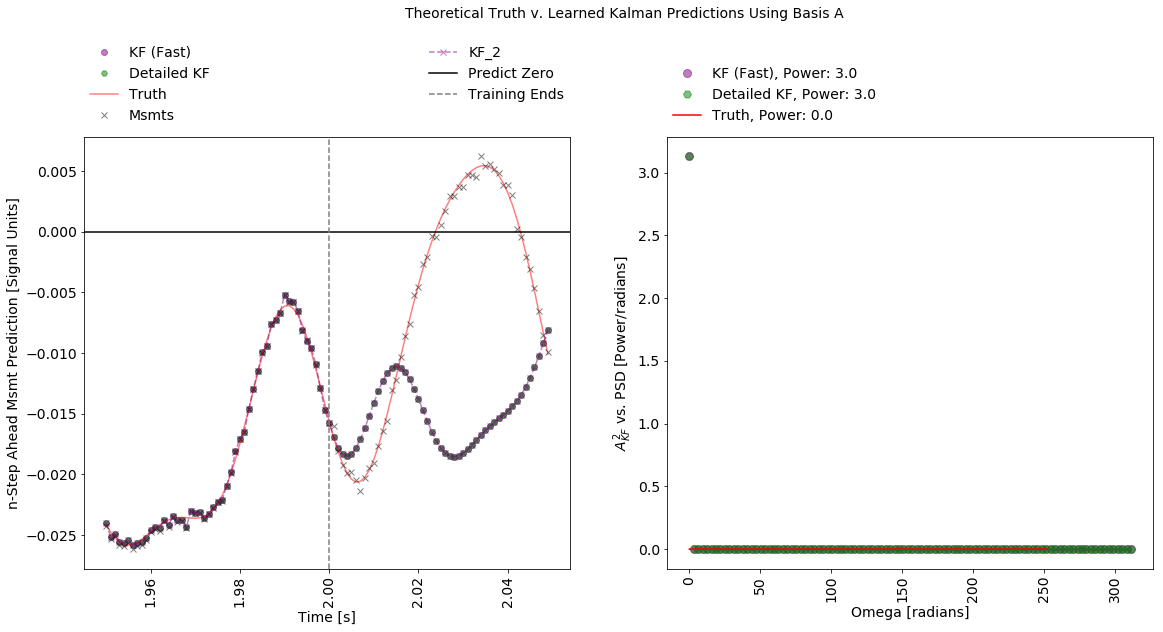

('My initial sigma, R =', 0.1, 0.1)


In [15]:
from ML_Risk import Create_KF_Experiment

Test_Object_4 = Create_KF_Experiment(bayes_params_, filename0_, savetopath_, max_it_, exp_params_, kalman_params_, 
                                    msmt_noise_params_, true_noise_params_, 
                                    user_defined_variance=None, skip_msmts=skip)

Test_Object_4.run_test_KF()
print('My initial sigma, R =', Test_Object_4.optimal_sigma, Test_Object_4.optimal_R)

Also note that true noise PSD generation is rounded such that power is zero  - I need to check why it is doing that.

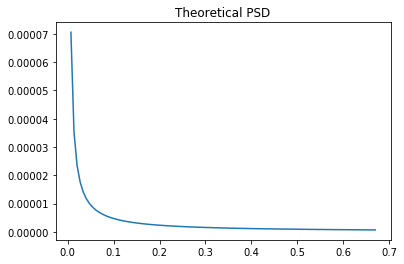

('Power (unrounded)', 0.0015676703229580999)


In [14]:
Test_Object_4.beta_z_truePSD() # call it again just to be on the safe side
import matplotlib.pyplot as plt
zoom_in= Test_Object_4.J + 100
plt.figure()
plt.title('Theoretical PSD')
plt.plot(Test_Object_4.true_w_axis[Test_Object_4.J:zoom_in], Test_Object_4.true_S_twosided[Test_Object_4.J:zoom_in])
plt.show()

print("Power (unrounded)", Test_Object_4.true_S_norm)

So the filter failed at learning the spectrum based on untuned parameters.

Let's optimise:

In [16]:
Test_Object_4.naive_implementation()
Test_Object_4.get_tuned_params()
Test_Object_4.set_tuned_params()

Time Taken for BR Map:  14161.6945438
Optimal params fore prediction and forecasting [  4.45248804e-05   7.93285197e-08] [  3.85926870e-05   8.34472543e-08]


See the optimisation results:

Optimal params [  4.45248804e-05   7.93285197e-08] [ 0.05682651  0.61965168]
Prediction
Loss Minimising Point Index: 8
Optimal Hyper Parameters:  [  4.45248804e-05   7.93285197e-08]
Loss Value 9.05409647415e-08
Forecasting
Loss Minimising Point Index: 22
Optimal Hyper Parameters:  [ 0.05682651  0.61965168]
Loss Value 0.000132226700609


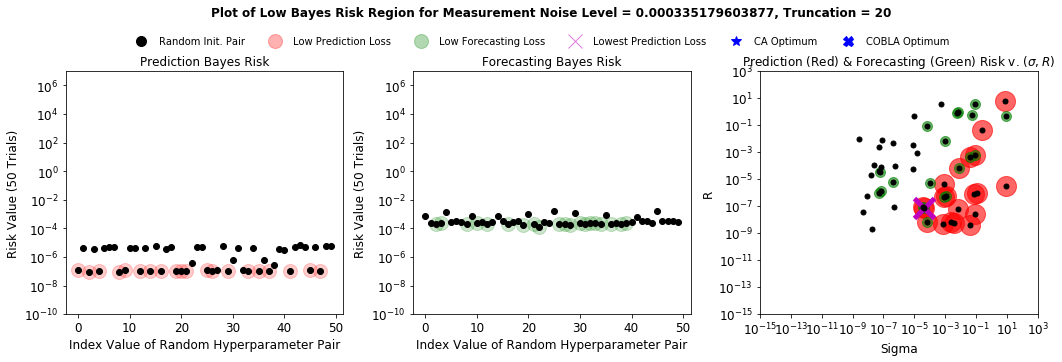

In [18]:
from plot_BR import Plot_BR_Results
filename_and_path_BR_4 = './'+str(Test_Object_4.filename_BR)+'.npz'
plotter_BR_4 = Plot_BR_Results(filename_and_path_BR_4)
plotter_BR_4.make_plot()

And, create all the cool data using a tuned filter:

In [ ]:
from plot_KF import Plot_KF_Results
Test_Object_4.ensemble_avg_predictions()
filename_and_path_KF_4 = './'+str(Test_Object_4.filename_KF)+'.npz'
plotter_KF_4 = Plot_KF_Results(exp_params_, filename_and_path_KF_4)
plotter_KF_4.make_plot()
plotter_KF_4.show_one_prediction()